In [1]:
import prior

dataset = prior.load_dataset("procthor-10k")
dataset

[AI2-THOR WARNING] There has been an update to ProcTHOR-10K that must be used with AI2-THOR version 5.0+. To use the new version of ProcTHOR-10K, please update AI2-THOR to version 5.0+ by running:
    pip install --upgrade ai2thor
Alternatively, to downgrade to the old version of ProcTHOR-10K, run:
   prior.load_dataset("procthor-10k", revision="ab3cacd0fc17754d4c080a3fd50b18395fae8647")


Loading test: 100%|██████████| 1000/1000 [00:00<00:00, 12303.22it/s]


DatasetDict(
    train=Dataset(
    dataset=procthor-dataset,
    size=10000,
    split=train
),
    val=Dataset(
    dataset=procthor-dataset,
    size=1000,
    split=val
),
    test=Dataset(
    dataset=procthor-dataset,
    size=1000,
    split=test
)
)

In [2]:
from ai2thor.controller import Controller


house = dataset["train"][3]
controller = Controller(scene=house, snapToGrid=False, rotateStepDegrees=30)
event = controller.step("Pass")
spawn = event.metadata["agent"]["position"]

/home/juyuanli/miniconda3/envs/nav_assistant/lib/python3.11/site-packages/ai2thor/platform.py:154: UserWarning: could not connect to X Display: 5, Can't connect to display ":5": b'Authorization required, but no authorization protocol specified\n'
  warnings.warn(


In [3]:
import numpy as np
def teleport(controller, target=None):
    event = controller.step("GetReachablePositions")
    reachable_positions = event.metadata["actionReturn"]
    # Pick a random target
    if target is None:
        target = np.random.choice(reachable_positions)

    event = controller.step(
        action="TeleportFull",
        x=target["x"],
        y=target["y"],
        z=target["z"],
        rotation={"x": 0, "y": 0, "z": 0},
        horizon=0,
        standing=True
    )

    return event


In [4]:
from rl import PPO, ActorCritic, Env, RolloutBuffer, ClipEnv, CLIPNovelty
from models import LSTMActor, LSTMCritic, FrozenResNetEncoder, SlidingWindowTransformerActor, SlidingWindowTransformerCritic
from cons import MINIBATCHES, EPISODE_STEPS, FEAT_DIM, NUM_ACTIONS, DEVICE

In [5]:
import torch
import matplotlib.pyplot as plt
from rl import save_actor_critic

def train(controller, name: str, ppo: PPO, env: Env, actor_critic: ActorCritic, total_updates=10):
    event = controller.step("Pass")  # prime
    rewards = []
    episode_rewards = []
    for upd in range(total_updates):
        buf = RolloutBuffer()
        for mb in range(MINIBATCHES):
            # collect episodes
            episode_seq = []
            episode_reward = 0
            actions_seq = []
            for t in range(1, EPISODE_STEPS + 1):
                with torch.no_grad():
                    obs_t = ppo.obs_from_event(event)  # (C,H,W)
                    obs_t_encoded = actor_critic.actor_critic_encoder(obs_t.unsqueeze(0).unsqueeze(0)).squeeze(0).squeeze(0)
                    obs_seq = torch.stack(episode_seq + [obs_t_encoded], dim=0).unsqueeze(0).to(device=DEVICE)

                if len(actions_seq) == 0:
                    actions_seq.append(torch.randint(0, NUM_ACTIONS, (1, 1)).item())
                
                actions_tensor = torch.tensor(actions_seq, dtype=torch.long, device=DEVICE).unsqueeze(0)
                logits, value = ppo.act_and_value(obs_seq, actions_tensor, actor_critic)
                dist = torch.distributions.Categorical(logits=logits)
                action_idx = dist.sample()
                logp = dist.log_prob(action_idx)
                
                action_idx, logp = action_idx.item(), logp.item()
                event, reward = env.step_env(controller, action_idx)
                done = t == EPISODE_STEPS

                # store one step
                buf.add(obs_t_encoded, action_idx, logp, reward, value, done)
                episode_seq.append(obs_t_encoded)
                rewards.append(reward)
                actions_seq.append(action_idx)
                
                episode_reward += reward / EPISODE_STEPS

                # 50% chance of teleport
                if done:
                    env.reset()
                    if np.random.rand() > 0.5:
                        event = teleport(controller)
            episode_rewards.append(episode_reward)
                
        ppo.ppo_update(buf, actor_critic)
        save_actor_critic(actor_critic, name)
        
        print(f"Update {upd+1}/{total_updates} — steps: {len(buf)}")
        plt.plot(rewards)
        plt.show()
        plt.plot(episode_rewards)
        plt.show()
    return buf, rewards

In [6]:
ENTROPY_COEF = 0.08

ppo = PPO(ENTROPY_COEF)
encoder = FrozenResNetEncoder()
actor = SlidingWindowTransformerActor(FEAT_DIM, NUM_ACTIONS)
critic = SlidingWindowTransformerCritic(FEAT_DIM)
clip_novelty = CLIPNovelty()
clip_env = ClipEnv(clip_novelty)
clip_actor_critic = ActorCritic(encoder, actor, critic)


[PPO] Epoch 0: Loss=88.9300, Policy=0.0051, Value=178.0140
[PPO] Epoch 10: Loss=73.6717, Policy=0.0240, Value=147.4499
[PPO] Epoch 20: Loss=59.0749, Policy=-0.0006, Value=118.3159
[PPO] Epoch 30: Loss=52.1765, Policy=0.0032, Value=104.5040
Approx KL Learned: 0.021993588656187057
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 1/10 — steps: 4096


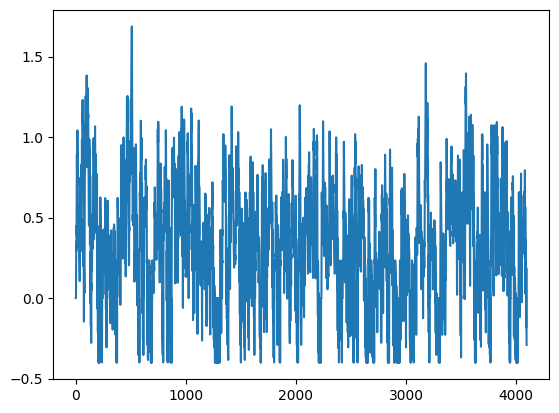

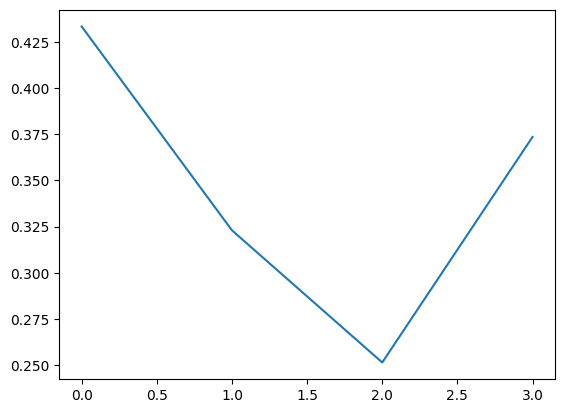

[PPO] Epoch 0: Loss=84.9362, Policy=0.0061, Value=170.0285
[PPO] Epoch 10: Loss=70.1783, Policy=-0.0010, Value=140.5255
[PPO] Epoch 20: Loss=63.6913, Policy=-0.0044, Value=127.5576
[PPO] Epoch 30: Loss=58.7561, Policy=-0.0053, Value=117.6879
Approx KL Learned: 0.015570243820548058
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 2/10 — steps: 4096


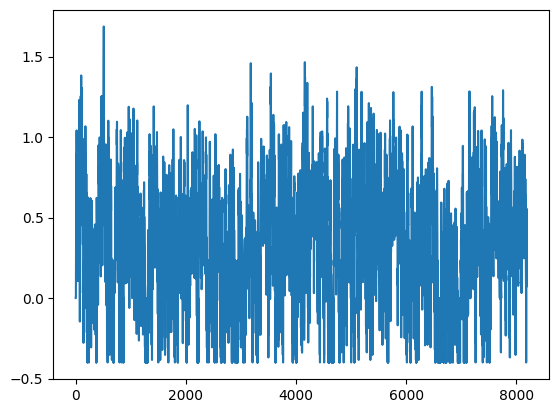

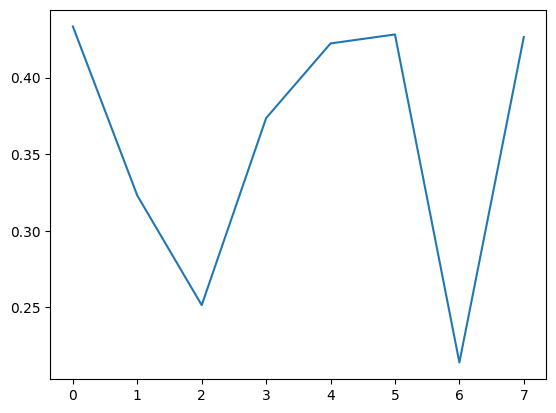

[PPO] Epoch 0: Loss=90.5958, Policy=0.0011, Value=181.3535
[PPO] Epoch 10: Loss=73.6808, Policy=-0.0016, Value=147.5279
[PPO] Epoch 20: Loss=59.8659, Policy=-0.0063, Value=119.9071
[PPO] Epoch 30: Loss=52.6743, Policy=-0.0110, Value=105.5316
Approx KL Learned: 0.014135204255580902
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 3/10 — steps: 4096


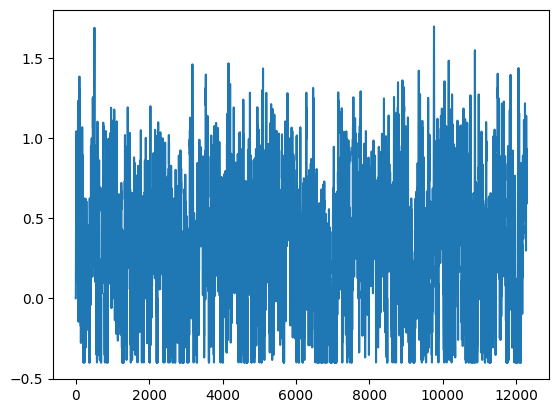

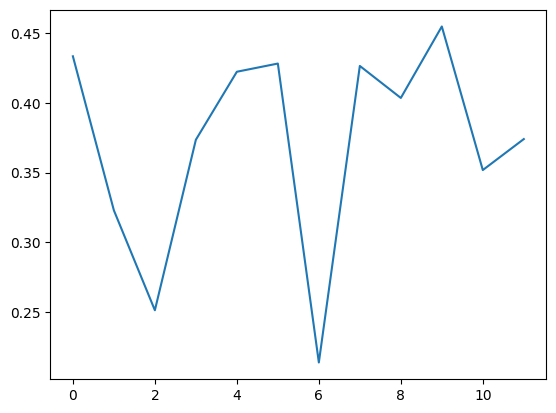

[PPO] Epoch 0: Loss=111.0416, Policy=0.0034, Value=222.2418
[PPO] Epoch 10: Loss=82.8601, Policy=0.0015, Value=165.8822
[PPO] Epoch 20: Loss=67.8231, Policy=-0.0025, Value=135.8174
[PPO] Epoch 30: Loss=62.2316, Policy=-0.0053, Value=124.6390
Approx KL Learned: 0.01370660588145256
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 4/10 — steps: 4096


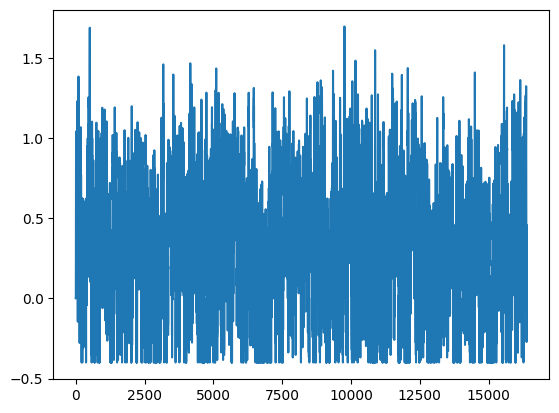

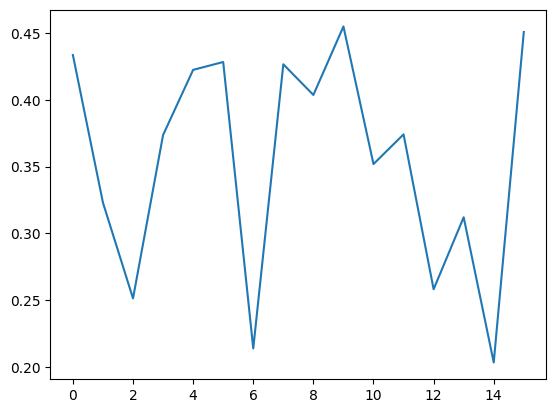

[PPO] Epoch 0: Loss=89.4674, Policy=0.0025, Value=179.0935
[PPO] Epoch 10: Loss=81.2118, Policy=-0.0031, Value=162.5897
[PPO] Epoch 20: Loss=67.0896, Policy=-0.0029, Value=134.3459
[PPO] Epoch 30: Loss=55.6479, Policy=-0.0049, Value=111.4656
Approx KL Learned: 0.013757103122770786
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 5/10 — steps: 4096


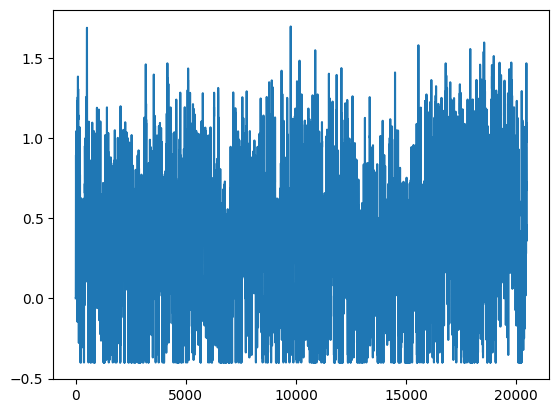

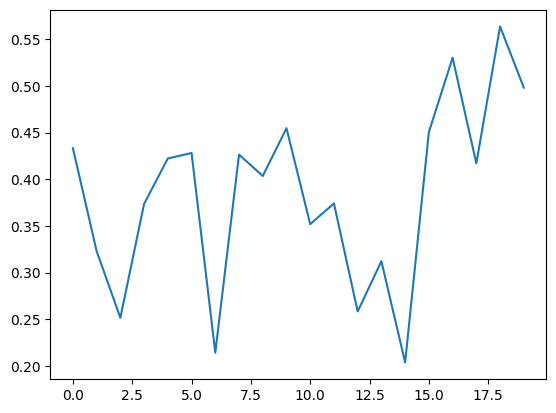

[PPO] Epoch 0: Loss=91.9568, Policy=0.0011, Value=184.0711
[PPO] Epoch 10: Loss=81.1724, Policy=-0.0034, Value=162.5070
[PPO] Epoch 20: Loss=66.5782, Policy=-0.0099, Value=133.3305
[PPO] Epoch 30: Loss=55.2894, Policy=-0.0152, Value=110.7653
Approx KL Learned: 0.018713384866714478
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 6/10 — steps: 4096


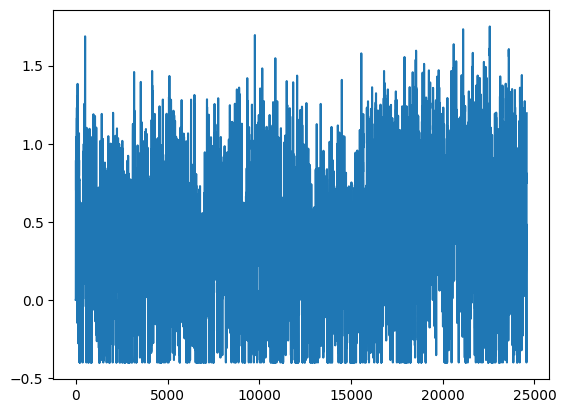

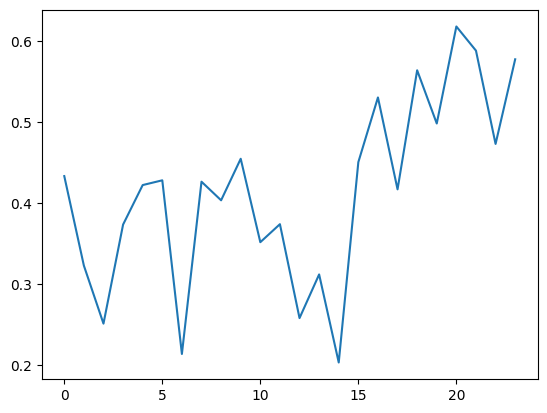

[PPO] Epoch 0: Loss=88.4106, Policy=0.0022, Value=176.9739
[PPO] Epoch 10: Loss=73.9983, Policy=0.0063, Value=148.1410
[PPO] Epoch 20: Loss=65.5503, Policy=0.0021, Value=131.2552
[PPO] Epoch 30: Loss=58.4819, Policy=0.0007, Value=117.1206
Approx KL Learned: 0.012776408344507217
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 7/10 — steps: 4096


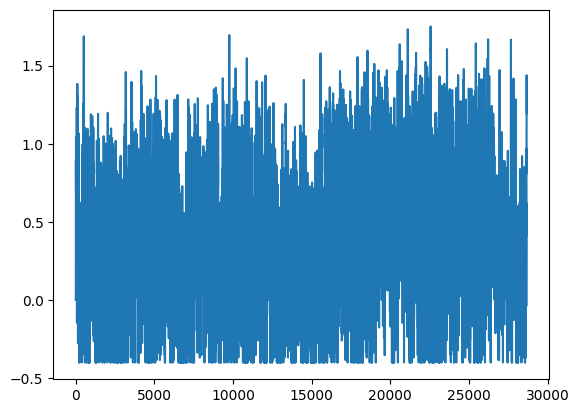

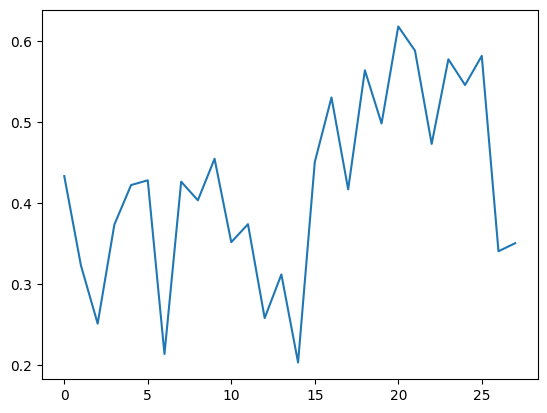

[PPO] Epoch 0: Loss=82.5423, Policy=0.0018, Value=165.2379
[PPO] Epoch 10: Loss=64.8400, Policy=-0.0036, Value=129.8403
[PPO] Epoch 20: Loss=58.4444, Policy=-0.0074, Value=117.0570
[PPO] Epoch 30: Loss=54.3603, Policy=-0.0119, Value=108.8963
Approx KL Learned: 0.013159126043319702
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 8/10 — steps: 4096


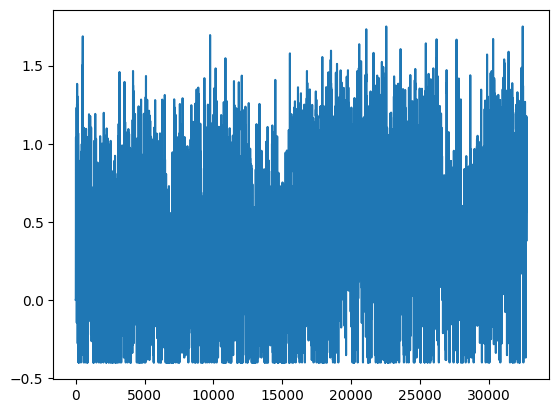

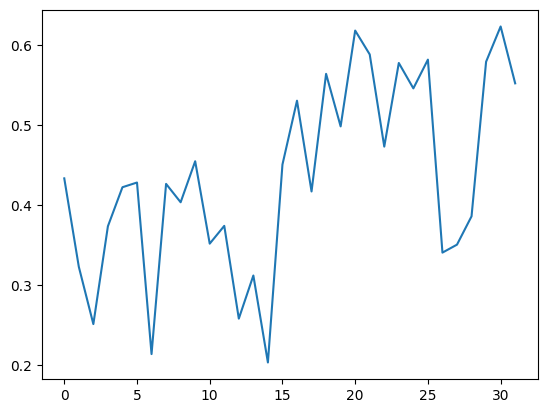

[PPO] Epoch 0: Loss=78.5459, Policy=0.0040, Value=157.2393
[PPO] Epoch 10: Loss=60.4914, Policy=-0.0018, Value=121.1386
[PPO] Epoch 20: Loss=54.1723, Policy=-0.0071, Value=108.5118
[PPO] Epoch 30: Loss=44.3297, Policy=-0.0078, Value=88.8280
Approx KL Learned: 0.0119203245267272
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 9/10 — steps: 4096


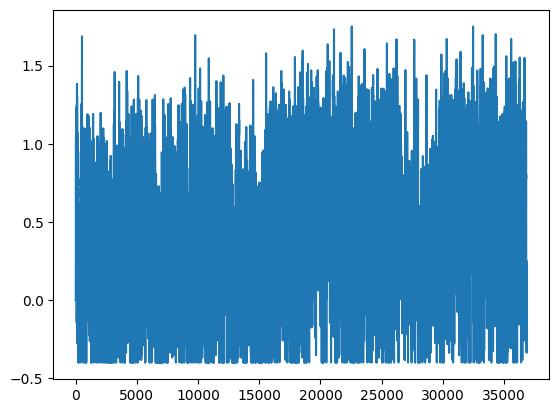

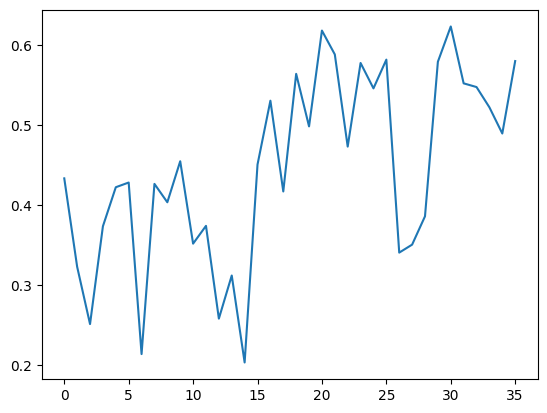

[PPO] Epoch 0: Loss=95.3298, Policy=0.0017, Value=190.8060
[PPO] Epoch 10: Loss=71.2337, Policy=-0.0042, Value=142.6221
[PPO] Epoch 20: Loss=56.8385, Policy=-0.0080, Value=113.8386
[PPO] Epoch 30: Loss=51.6924, Policy=-0.0131, Value=103.5588
Approx KL Learned: 0.017402641475200653
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 10/10 — steps: 4096


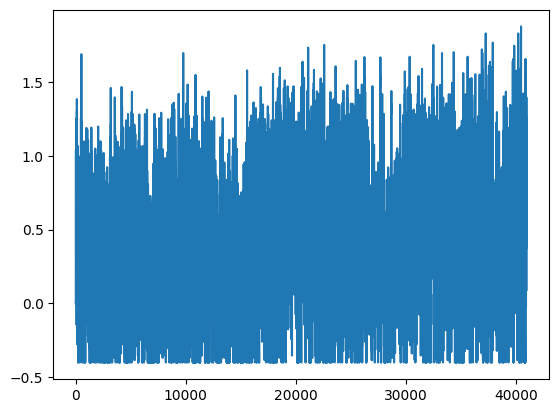

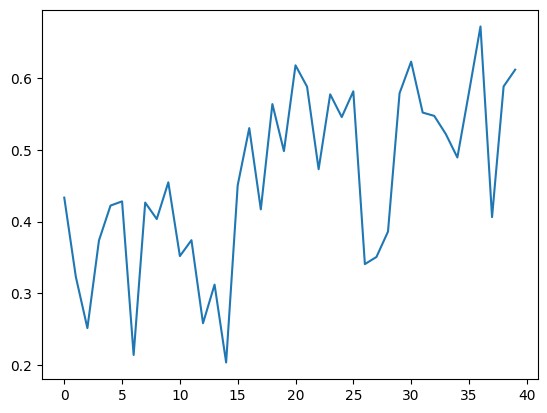

In [7]:
buf, rewards = train(controller, "clip_actor_critic_checkpoint_long_training.pt", ppo, clip_env, clip_actor_critic, 10)

[PPO] Epoch 0: Loss=70.9477, Policy=0.0046, Value=142.0332
[PPO] Epoch 10: Loss=53.0609, Policy=0.0121, Value=106.2433
[PPO] Epoch 20: Loss=49.0273, Policy=-0.0006, Value=98.2034
[PPO] Epoch 30: Loss=44.0378, Policy=-0.0089, Value=88.2390
Approx KL Learned: 0.15264606475830078
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 1/10 — steps: 4096


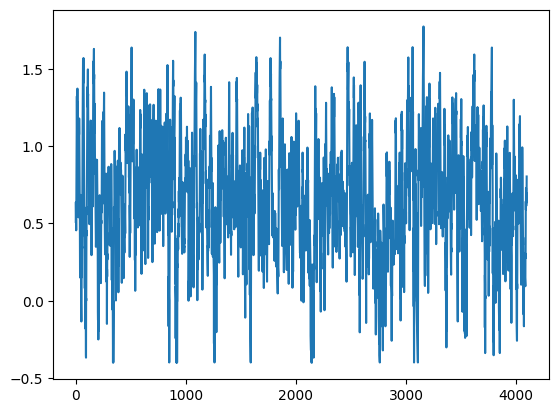

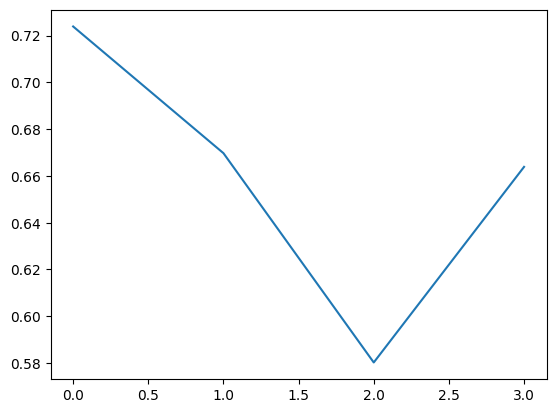

[PPO] Epoch 0: Loss=83.2329, Policy=0.0065, Value=166.6063
[PPO] Epoch 10: Loss=67.4079, Policy=0.0239, Value=134.9081
[PPO] Epoch 20: Loss=56.2694, Policy=0.0060, Value=112.6722
[PPO] Epoch 30: Loss=48.4192, Policy=-0.0032, Value=96.9951
Approx KL Learned: 0.007108601741492748
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 2/10 — steps: 4096


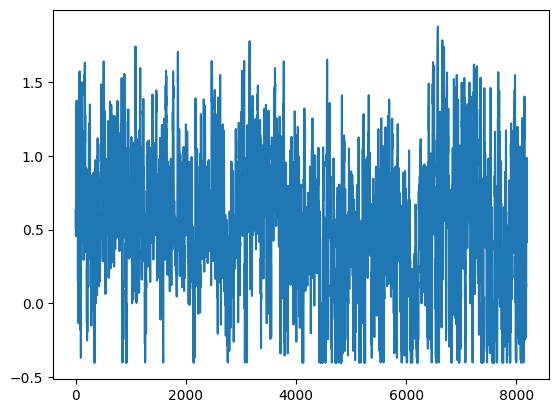

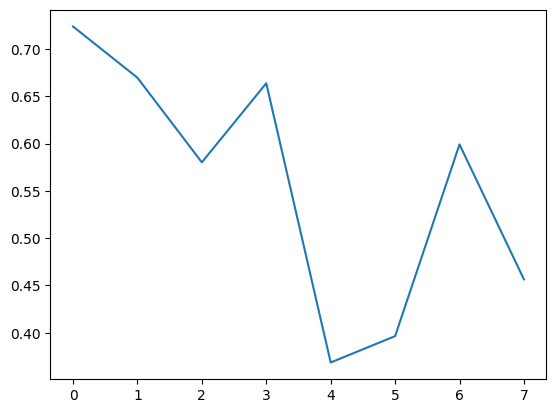

[PPO] Epoch 0: Loss=95.3544, Policy=0.0014, Value=190.8616
[PPO] Epoch 10: Loss=66.4058, Policy=-0.0026, Value=132.9742
[PPO] Epoch 20: Loss=56.9063, Policy=-0.0066, Value=113.9833
[PPO] Epoch 30: Loss=50.0378, Policy=-0.0103, Value=100.2542
Approx KL Learned: 0.019446520134806633
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 3/10 — steps: 4096


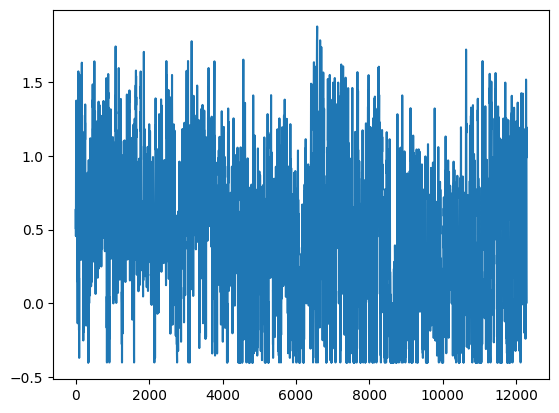

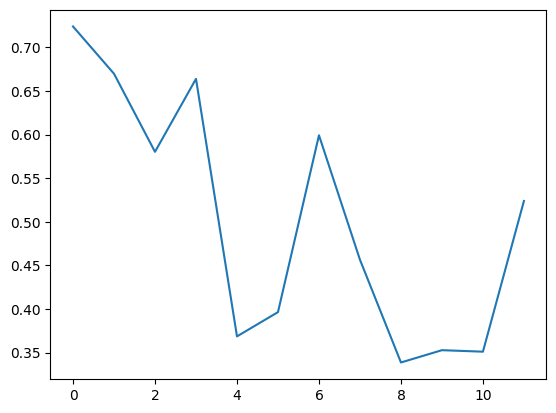

[PPO] Epoch 0: Loss=127.7081, Policy=0.0035, Value=255.5477
[PPO] Epoch 10: Loss=90.1544, Policy=-0.0041, Value=180.4543
[PPO] Epoch 20: Loss=68.3609, Policy=-0.0111, Value=136.8856
[PPO] Epoch 30: Loss=61.7626, Policy=-0.0176, Value=123.7048
Approx KL Learned: 0.027132103219628334
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 4/10 — steps: 4096


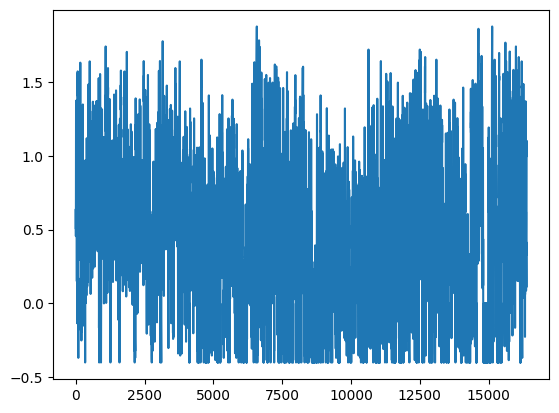

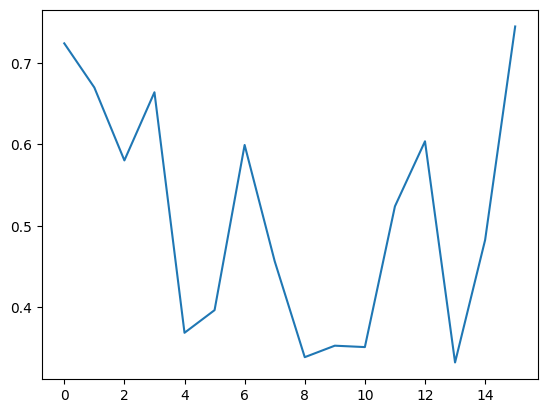

[PPO] Epoch 0: Loss=89.5451, Policy=0.0041, Value=179.2246
[PPO] Epoch 10: Loss=65.9473, Policy=-0.0013, Value=132.0418
[PPO] Epoch 20: Loss=44.1483, Policy=-0.0116, Value=88.4620
[PPO] Epoch 30: Loss=36.2645, Policy=-0.0108, Value=72.6971
Approx KL Learned: 0.07331935316324234
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 5/10 — steps: 4096


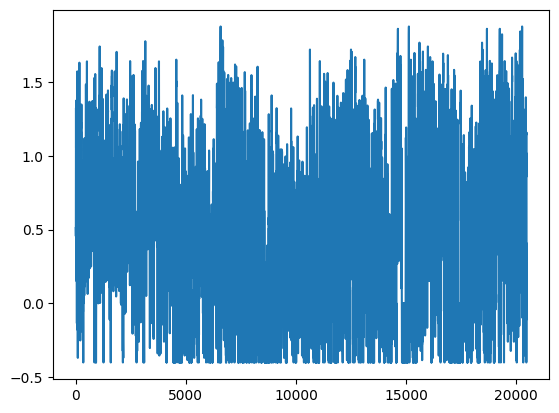

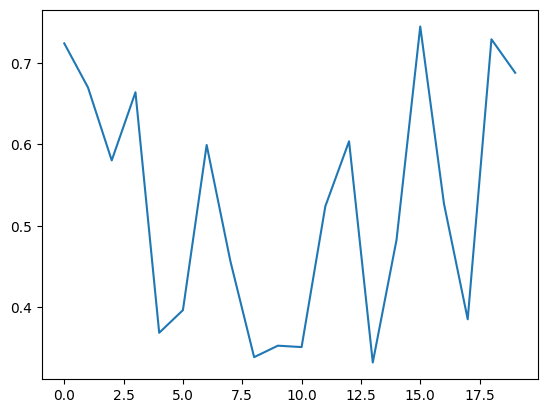

[PPO] Epoch 0: Loss=100.9363, Policy=0.0042, Value=202.0171
[PPO] Epoch 10: Loss=78.9308, Policy=-0.0071, Value=158.0267
[PPO] Epoch 20: Loss=68.9122, Policy=-0.0140, Value=138.0046
[PPO] Epoch 30: Loss=63.6046, Policy=-0.0211, Value=127.4019
Approx KL Learned: 0.032076217234134674
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 6/10 — steps: 4096


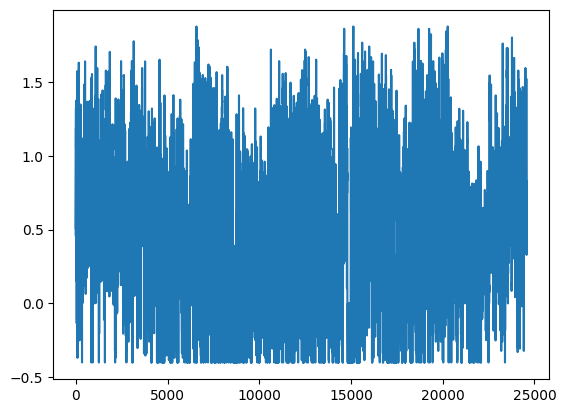

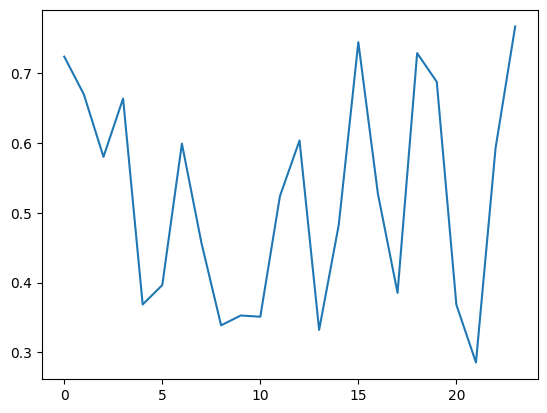

[PPO] Epoch 0: Loss=83.1606, Policy=0.0046, Value=166.4530
[PPO] Epoch 10: Loss=66.7907, Policy=-0.0051, Value=133.7293
[PPO] Epoch 20: Loss=57.9218, Policy=-0.0119, Value=116.0026
[PPO] Epoch 30: Loss=49.2838, Policy=-0.0005, Value=98.7088
Approx KL Learned: 0.04188523441553116
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 7/10 — steps: 4096


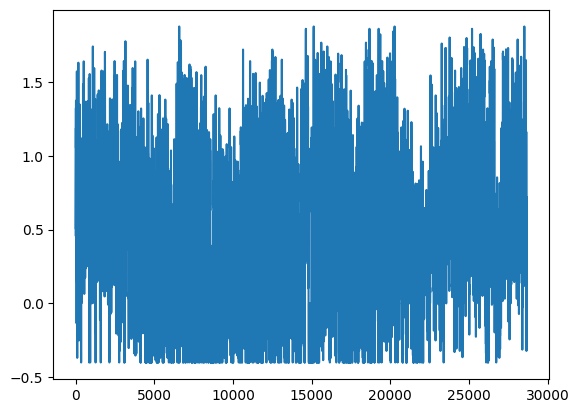

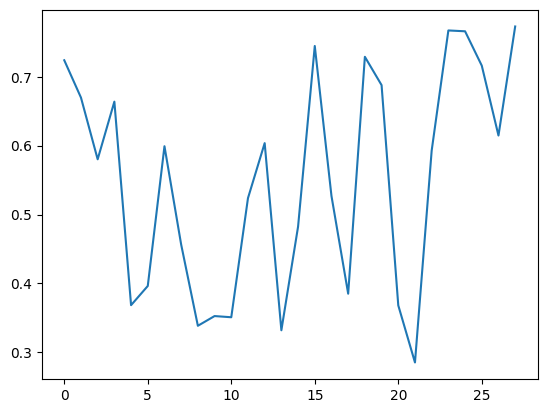

[PPO] Epoch 0: Loss=71.4654, Policy=0.0073, Value=143.0497
[PPO] Epoch 10: Loss=53.0982, Policy=0.0187, Value=106.2891
[PPO] Epoch 20: Loss=47.0114, Policy=-0.0076, Value=94.1702
[PPO] Epoch 30: Loss=44.7595, Policy=0.0093, Value=89.6246
Approx KL Learned: 0.1447896957397461
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 8/10 — steps: 4096


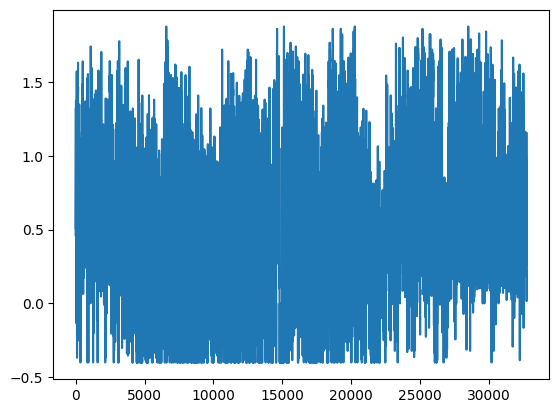

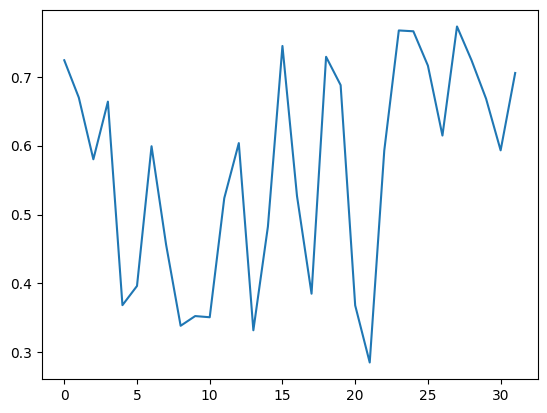

[PPO] Epoch 0: Loss=72.9468, Policy=0.0021, Value=146.0426
[PPO] Epoch 10: Loss=45.2135, Policy=-0.0128, Value=90.6110
[PPO] Epoch 20: Loss=37.4766, Policy=-0.0142, Value=75.1373
[PPO] Epoch 30: Loss=32.3875, Policy=-0.0186, Value=64.9706
Approx KL Learned: 0.024285409599542618
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 9/10 — steps: 4096


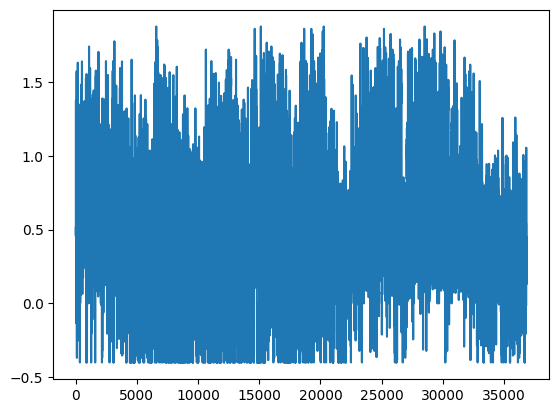

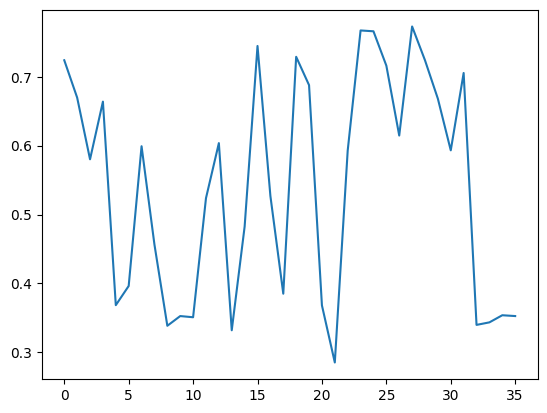

[PPO] Epoch 0: Loss=56.5988, Policy=0.0016, Value=113.3447
[PPO] Epoch 10: Loss=40.8591, Policy=-0.0119, Value=81.8905
[PPO] Epoch 20: Loss=33.1732, Policy=-0.0191, Value=66.5334
[PPO] Epoch 30: Loss=25.4240, Policy=-0.0307, Value=51.0571
Approx KL Learned: 0.026637090370059013
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 10/10 — steps: 4096


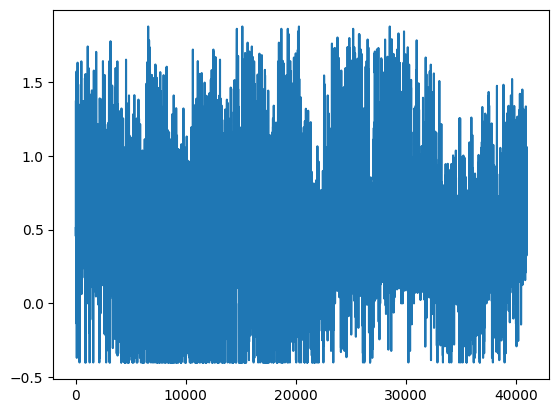

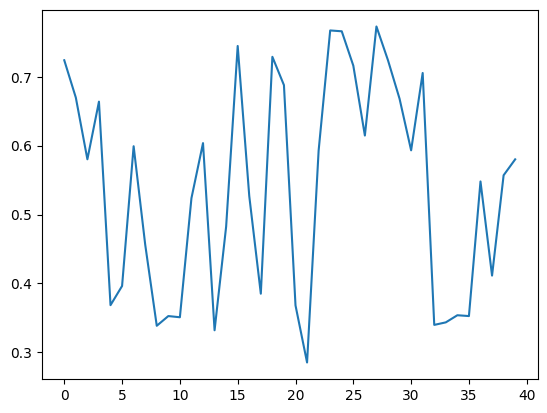

In [10]:
buf, rewards = train(controller, "clip_actor_critic_checkpoint_long_training.pt", ppo, clip_env, clip_actor_critic, 10)

In [11]:
from cons import ACTIONS
from collections import deque
import matplotlib.pyplot as plt
import numpy as np
from typing import Callable
import imageio


def inference(get_distribution: Callable[[torch.Tensor, ActorCritic], torch.distributions.Categorical], init_position: dict[str, float], env: Env, actor_critic: ActorCritic, plot=True):
    n = 256
    n_row = 32
    positions = []

    plt.figure(figsize=(n // n_row * 2, n_row * 2))
    event = teleport(controller, init_position)
    episode_seq = deque(maxlen=EPISODE_STEPS)
    actions_seq = deque(maxlen=EPISODE_STEPS)
    raw_obs = []
    for t in range(1, n + 1):
        positions.append([event.metadata["agent"]["position"]["x"], event.metadata["agent"]["position"]["z"]])
        with torch.no_grad():
            obs_t = ppo.obs_from_event(event)  # (C,H,W)
            obs_t_encoded = actor_critic.actor_critic_encoder(obs_t.unsqueeze(0).unsqueeze(0)).squeeze(0).squeeze(0)
            obs_seq = torch.stack(list(episode_seq) + [obs_t_encoded], dim=0).unsqueeze(0).to(device=DEVICE)

        if len(actions_seq) == 0:
            actions_seq.append(torch.randint(0, NUM_ACTIONS, (1, 1)).item())
        
        actions_tensor = torch.tensor(actions_seq, dtype=torch.long, device=DEVICE).unsqueeze(0)
        dist = get_distribution(obs_seq, actions_tensor, actor_critic)
        action_idx = dist.sample()
        logp = dist.log_prob(action_idx)
        
        action_idx, logp = action_idx.item(), logp.item()
        event, reward = env.step_env(controller, action_idx)

        # store one step
        episode_seq.append(obs_t_encoded)
        actions_seq.append(action_idx)
        raw_obs.append(obs_t)
        
        if plot:
            # Plot frame and action
            plt.subplot(n_row, n // n_row, t)
            plt.title("action: " + ACTIONS[action_idx] + ", r: " + f"{reward:.2f}" + "\n, prob = " + f"{torch.exp(dist.log_prob(torch.tensor([0, 1, 2], device=DEVICE))).cpu().numpy()}", fontsize=5)
            plt.axis(False)
            plt.imshow(event.frame)
    if plot:
        plt.tight_layout()
        plt.show()
        
        # ---- Plot 2D trajectory of the agent ----
        positions = np.array(positions)
        plt.figure(figsize=(4, 4))
        plt.plot(positions[:, 0], positions[:, 1], "-o", markersize=3)
        plt.xlabel("x")
        plt.ylabel("z")
        plt.title("Agent trajectory over n steps")
        plt.grid(True)
        plt.show()

    return raw_obs

def inference_video_mp4(
    get_distribution,
    init_position: dict[str, float],
    env: Env,
    actor_critic: ActorCritic,
    video_path="rollout.mp4",
    fps=10,
    n_steps=512
):
    episode_seq = deque(maxlen=EPISODE_STEPS)
    actions_seq = deque(maxlen=EPISODE_STEPS)

    writer = imageio.get_writer(video_path, fps=fps)

    # start episode
    event = teleport(controller, init_position)
    positions = []

    for t in range(1, n_steps + 1):

        # ---- Add current frame to video ----
        writer.append_data(event.frame[:, :, ::-1])   # convert RGB→BGR if needed

        # track positions
        positions.append([
            event.metadata["agent"]["position"]["x"],
            event.metadata["agent"]["position"]["z"],
        ])

        with torch.no_grad():
            obs_t = ppo.obs_from_event(event)  
            obs_enc = actor_critic.actor_critic_encoder(
                obs_t.unsqueeze(0).unsqueeze(0)
            ).squeeze(0).squeeze(0)

            obs_seq = torch.stack(
                list(episode_seq) + [obs_enc], dim=0
            ).unsqueeze(0).to(DEVICE)

        # ---- Action ----
        if len(actions_seq) == 0:
            actions_seq.append(torch.randint(0, NUM_ACTIONS, ()).item())

        actions_tensor = torch.tensor(
            actions_seq, dtype=torch.long, device=DEVICE
        ).unsqueeze(0)

        dist = get_distribution(obs_seq, actions_tensor, actor_critic)
        action_idx = dist.sample().item()

        # ---- Step env ----
        event, reward = env.step_env(controller, action_idx)

        # ---- Store ----
        episode_seq.append(obs_enc)
        actions_seq.append(action_idx)

    writer.close()
    print(f"[🎞️] Saved video to {video_path}")

    return positions


def get_distributions(obs_seq, actions_tensor, clip_actor_critic):
    logits, value = ppo.act_and_value(obs_seq, actions_tensor, clip_actor_critic)
    dist = torch.distributions.Categorical(logits=logits)
    return dist

event = teleport(controller)
init_pos = event.metadata["agent"]["position"]
inference_video_mp4(get_distributions, init_pos, clip_env, clip_actor_critic)

[🎞️] Saved video to rollout.mp4


[[2.2570314407348633, 3.081326484680176],
 [2.2570314407348633, 3.331326484680176],
 [2.2570314407348633, 3.581326484680176],
 [2.2570314407348633, 3.831326484680176],
 [2.2570314407348633, 4.081326484680176],
 [2.2570314407348633, 4.331326484680176],
 [2.2570314407348633, 4.331326484680176],
 [2.2570314407348633, 4.331326484680176],
 [2.4735379219055176, 4.456326484680176],
 [2.4735379219055176, 4.456326484680176],
 [2.7235379219055176, 4.456326484680176],
 [2.9735379219055176, 4.456326484680176],
 [3.2235379219055176, 4.456326484680176],
 [3.2235379219055176, 4.456326484680176],
 [3.4400441646575928, 4.331326484680176],
 [3.4400441646575928, 4.331326484680176],
 [3.4400441646575928, 4.331326484680176],
 [3.656550645828247, 4.456326484680176],
 [3.8730571269989014, 4.581326484680176],
 [3.8730571269989014, 4.581326484680176],
 [3.8730571269989014, 4.581326484680176],
 [4.089563369750977, 4.456326484680176],
 [4.089563369750977, 4.456326484680176],
 [4.214563369750977, 4.23982000350952

In [34]:
!pip install imageio imageio-ffmpeg

In [9]:
import clip

model, preprocess = clip.load("ViT-B/32", device=DEVICE)

In [10]:
import torch
import torch.nn.functional as F
import random

def preprocess_clip(x):
    # Resize to CLIP resolution
    x = F.interpolate(x, size=(224, 224), mode="bilinear", align_corners=False)
    # Normalize (CLIP standard mean/std)
    mean = torch.tensor([0.48145466, 0.4578275, 0.40821073], device=x.device).view(1, 3, 1, 1)
    std  = torch.tensor([0.26862954, 0.26130258, 0.27577711], device=x.device).view(1, 3, 1, 1)
    return (x - mean) / std

def get_average(input_img):
    # ---- 1. Sample 50 random images ----
    n = min(50, len(input_img))
    indices = random.sample(range(len(input_img)), n)
    imgs = torch.stack([input_img[i] for i in indices]).to(DEVICE)  # (50, 3, H, W)

    # ---- 2. Preprocess for CLIP ----
    imgs_clip = preprocess_clip(imgs).half()  # normalized, resized

    # ---- 3. Encode with CLIP visual encoder ----
    with torch.no_grad():
        embeds = model.visual(imgs_clip)       # (50, D)
        embeds = embeds / embeds.norm(dim=-1, keepdim=True)  # normalize to unit sphere

    # ---- 4. Compute cosine similarity ----
    sim_matrix = embeds @ embeds.T             # (50, 50)
    # Optional: remove self-similarity (diagonal = 1)
    sim_matrix.fill_diagonal_(0)

    # ---- 5. Summary statistics ----
    mean_sim = sim_matrix.mean().item()

    return mean_sim

for i in range(5):

    event = teleport(controller)
    init_pos = event.metadata["agent"]["position"]
    
    def get_distributions(obs_seq, actions_tensor, clip_actor_critic):
        logits, value = ppo.act_and_value(obs_seq, actions_tensor, clip_actor_critic)
        dist = torch.distributions.Categorical(logits=logits)
        return dist

    policy = inference(get_distributions, init_pos, clip_env, clip_actor_critic, False)

    def get_distributions(obs_seq, actions_tensor, clip_actor_critic):
        dist = torch.distributions.Categorical(probs=torch.tensor([0.5, 0.25, 0.25], device=DEVICE))
        return dist

    rand_policy = inference(get_distributions, init_pos, clip_env, clip_actor_critic, False)

    mean_policies = []
    mean_rands = []
    for i in range(10):
        mean_policy = get_average(policy)
        mean_rand = get_average(rand_policy)
        mean_policies.append(mean_policy)
        mean_rands.append(mean_rand)
    
    print("Policy: " + str(np.mean(np.array(mean_policies))))
    print("Rand: " + str(np.mean(np.array(mean_rands))))



Policy: 0.84921875
Rand: 0.790966796875
Policy: 0.867724609375
Rand: 0.836279296875
Policy: 0.835107421875
Rand: 0.752294921875
Policy: 0.83193359375
Rand: 0.7958984375
Policy: 0.868505859375
Rand: 0.871484375


<Figure size 1600x6400 with 0 Axes>

<Figure size 1600x6400 with 0 Axes>

<Figure size 1600x6400 with 0 Axes>

<Figure size 1600x6400 with 0 Axes>

<Figure size 1600x6400 with 0 Axes>

<Figure size 1600x6400 with 0 Axes>

<Figure size 1600x6400 with 0 Axes>

<Figure size 1600x6400 with 0 Axes>

<Figure size 1600x6400 with 0 Axes>

<Figure size 1600x6400 with 0 Axes>

In [20]:
controller.stop()